In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe

/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


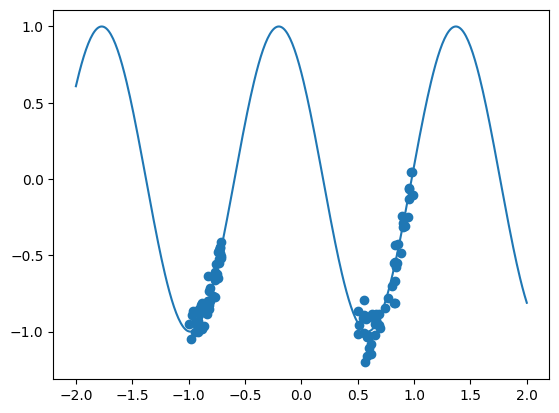

In [5]:
pyro.set_rng_seed(42)
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401)
y_test = x_test.mul(4).add(0.8).cos()


plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [32]:
class NN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.sequence = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50,1))

    def forward(self, x):
        return self.sequence(x)

In [33]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

y.shape

torch.Size([100, 1])

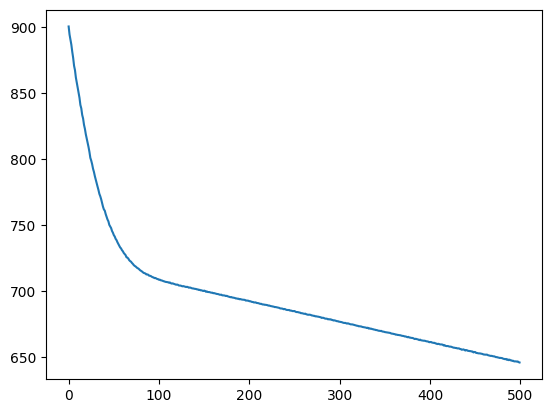

In [34]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale = prior)
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=1)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x))
guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(NN(), prior, obs_model, guide)

pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 500, callback)
    
plt.plot(elbos)

In [37]:
a, b = bnn.predict(x)

/home/riccardo/anaconda3/envs/bayesian/lib/python3.12/site-packages/tyxe/likelihoods.py:260: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  scale = predictions.var(dim).add(self.scale ** 2).sqrt()


In [36]:
def test_hom_gaussian_aggregate(agg_dim, scale):
    shape = (5, 4, 3)
    lik = tyxe.likelihoods.HomoskedasticGaussian(event_dim=1, dataset_size=-1, scale=scale)
    predictions = torch.randn(shape)
    means, scales = lik.aggregate_predictions(predictions, agg_dim)
    true_means = predictions.mean(agg_dim)
    true_scale = predictions.var(agg_dim).add(scale ** 2).sqrt()

    assert torch.allclose(means, true_means)
    assert torch.allclose(scales, true_scale)


def test_het_gaussian_aggregate(agg_dim):
    shape = (5, 4, 3)
    lik = tyxe.likelihoods.HeteroskedasticGaussian(event_dim=1, dataset_size=-1, positive_scale=True)
    pred_means = torch.randn(shape)
    pred_scales = torch.rand(shape)
    pred_precisions = pred_scales.pow(-2)
    predictions = torch.cat((pred_means, pred_scales), dim=-1)
    means, scales = lik.aggregate_predictions(predictions, agg_dim).chunk(2, dim=-1)
    true_means = pred_means.mul(pred_precisions).sum(agg_dim) / pred_precisions.sum(agg_dim)
    true_scale = pred_means.var(agg_dim).add(pred_scales.pow(2).mean(agg_dim)).sqrt()

    assert torch.allclose(means, true_means)
    assert torch.allclose(scales, true_scale)

In [ ]:
[(0, 0.1), (1, 1.), (2, 3.)]
agg_dim = 0
scale = 0.1
shape = (5, 4, 3)
lik = tyxe.likelihoods.HomoskedasticGaussian(event_dim=1, dataset_size=-1, scale=scale)
predictions = torch.randn(shape)
means, scales = lik.aggregate_predictions(predictions, agg_dim)
true_means = predictions.mean(agg_dim)
true_scale = predictions.var(agg_dim).add(scale ** 2).sqrt()

In [ ]:
shape = (1000, 100)
lik = tyxe.likelihoods.HeteroskedasticGaussian(event_dim=1, dataset_size=-1, positive_scale=True)
pred_means = torch.randn(shape)
pred_scales = torch.rand(shape)
pred_precisions = pred_scales.pow(-2)
predictions = torch.cat((pred_means,    ), dim=-1)
means, scales = lik.aggregate_predictions(predictions, agg_dim).chunk(2, dim=-1)
true_means = pred_means.mul(pred_precisions).sum(agg_dim) / pred_precisions.sum(agg_dim)
true_scale = pred_means.var(agg_dim).add(pred_scales.pow(2).mean(agg_dim)).sqrt()

In [ ]:
pred_scales

tensor([[0.3815, 0.2801, 0.1317,  ..., 0.2437, 0.8034, 0.1712],
        [0.7615, 0.3398, 0.6835,  ..., 0.1534, 0.0305, 0.2261],
        [0.9622, 0.2952, 0.1383,  ..., 0.8166, 0.6052, 0.5793],
        ...,
        [0.4901, 0.2598, 0.2767,  ..., 0.8547, 0.1360, 0.3650],
        [0.4732, 0.6956, 0.8050,  ..., 0.4887, 0.8104, 0.7729],
        [0.0054, 0.2795, 0.6807,  ..., 0.0734, 0.4525, 0.4119]])